In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Part B: Regression Problem**

In [ ]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [ ]:
import time
import math

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import IPython.display as ipd

from scipy.io import wavfile as wav

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CZ4042/hdb_price_prediction.csv')
df.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [ ]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [ ]:
from keras import backend as K

def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return (1 - SS_res/(SS_tot + K.epsilon()))



# **Q1**

**Real world datasets often have a mix of numeric and categorical features – this dataset is one such
example. To build models on such data, categorical features have to be encoded. Also, before
applying neural networks, it is a good practice to try simpler machine learning algorithms first.
For all models in Part B of the assignment, the following features should be used:**
- **Numeric features: dist_to_nearest_stn, dist_to_dhoby, degree_centrality,
eigenvector_centrality, remaining_lease_years, floor_area_sqm**
- **Categorical features: month, flat_model_type, storey_range**

**One-hot encoding should be applied on categorical features.**

**Standardisation should be performed on numeric features**

####**a. Divide the dataset (‘HDB_price_prediction.csv’) into train and test sets by using entries from year 2020 and before as training data (with the remaining data from year 2021 and 2022 used as test data).**

In [ ]:
df = df.drop(["full_address", "nearest_stn"], axis=1)
df.head()

,month,year,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [ ]:
# Split data

train_dataframe = df[df.year < 2021].reset_index(drop=True)
test_dataframe = df[df.year > 2020].reset_index(drop=True)

len(train_dataframe), len(test_dataframe)

(87370, 46042)

As the data include features having dependency on time (e.g. remaining_lease_years), it is reasonable to implement time-based split instead of random split.

####**b. Implement this neural network by following this tutorial from the Keras documentation which guides you through the process of using the Functional API to do so. After encoding / standardisation, the features should be concatenated. Your architecture should resemble the figure shown in Appendix A.**

In [ ]:
batch_size = 256

In [ ]:
train_ds = dataframe_to_dataset(train_dataframe)
test_ds = dataframe_to_dataset(test_dataframe)

train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [ ]:
def encodeInputFeature(categoricalDict, numericList):
  all_inputs = []
  all_features = []
  for cat, typ in categoricalDict.items():
    encoded_cat = keras.Input(shape=(1,), name=cat, dtype=typ)
    all_inputs.append(encoded_cat)
    if typ == "int64":
      all_features.append(encode_categorical_feature(encoded_cat, cat, train_ds, False))
    else:
      all_features.append(encode_categorical_feature(encoded_cat, cat, train_ds, True))
  for num in numericList:
    encoded_num = keras.Input(shape=(1,), name=num)
    all_inputs.append(encoded_num)
    all_features.append(encode_numerical_feature(encoded_num, num, train_ds))
  return all_inputs, layers.concatenate(all_features)

In [ ]:
categoricalDict = {
    "month": "int64",
    "flat_model_type": "string",
    "storey_range": "string"
}
numericList = ["dist_to_nearest_stn", "dist_to_dhoby", "degree_centrality", "eigenvector_centrality", "remaining_lease_years", "floor_area_sqm"]

all_inputs, all_features = encodeInputFeature(categoricalDict, numericList)

In [ ]:
x = layers.Dense(1, activation="linear")(all_features)
model = keras.Model(all_inputs, x)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

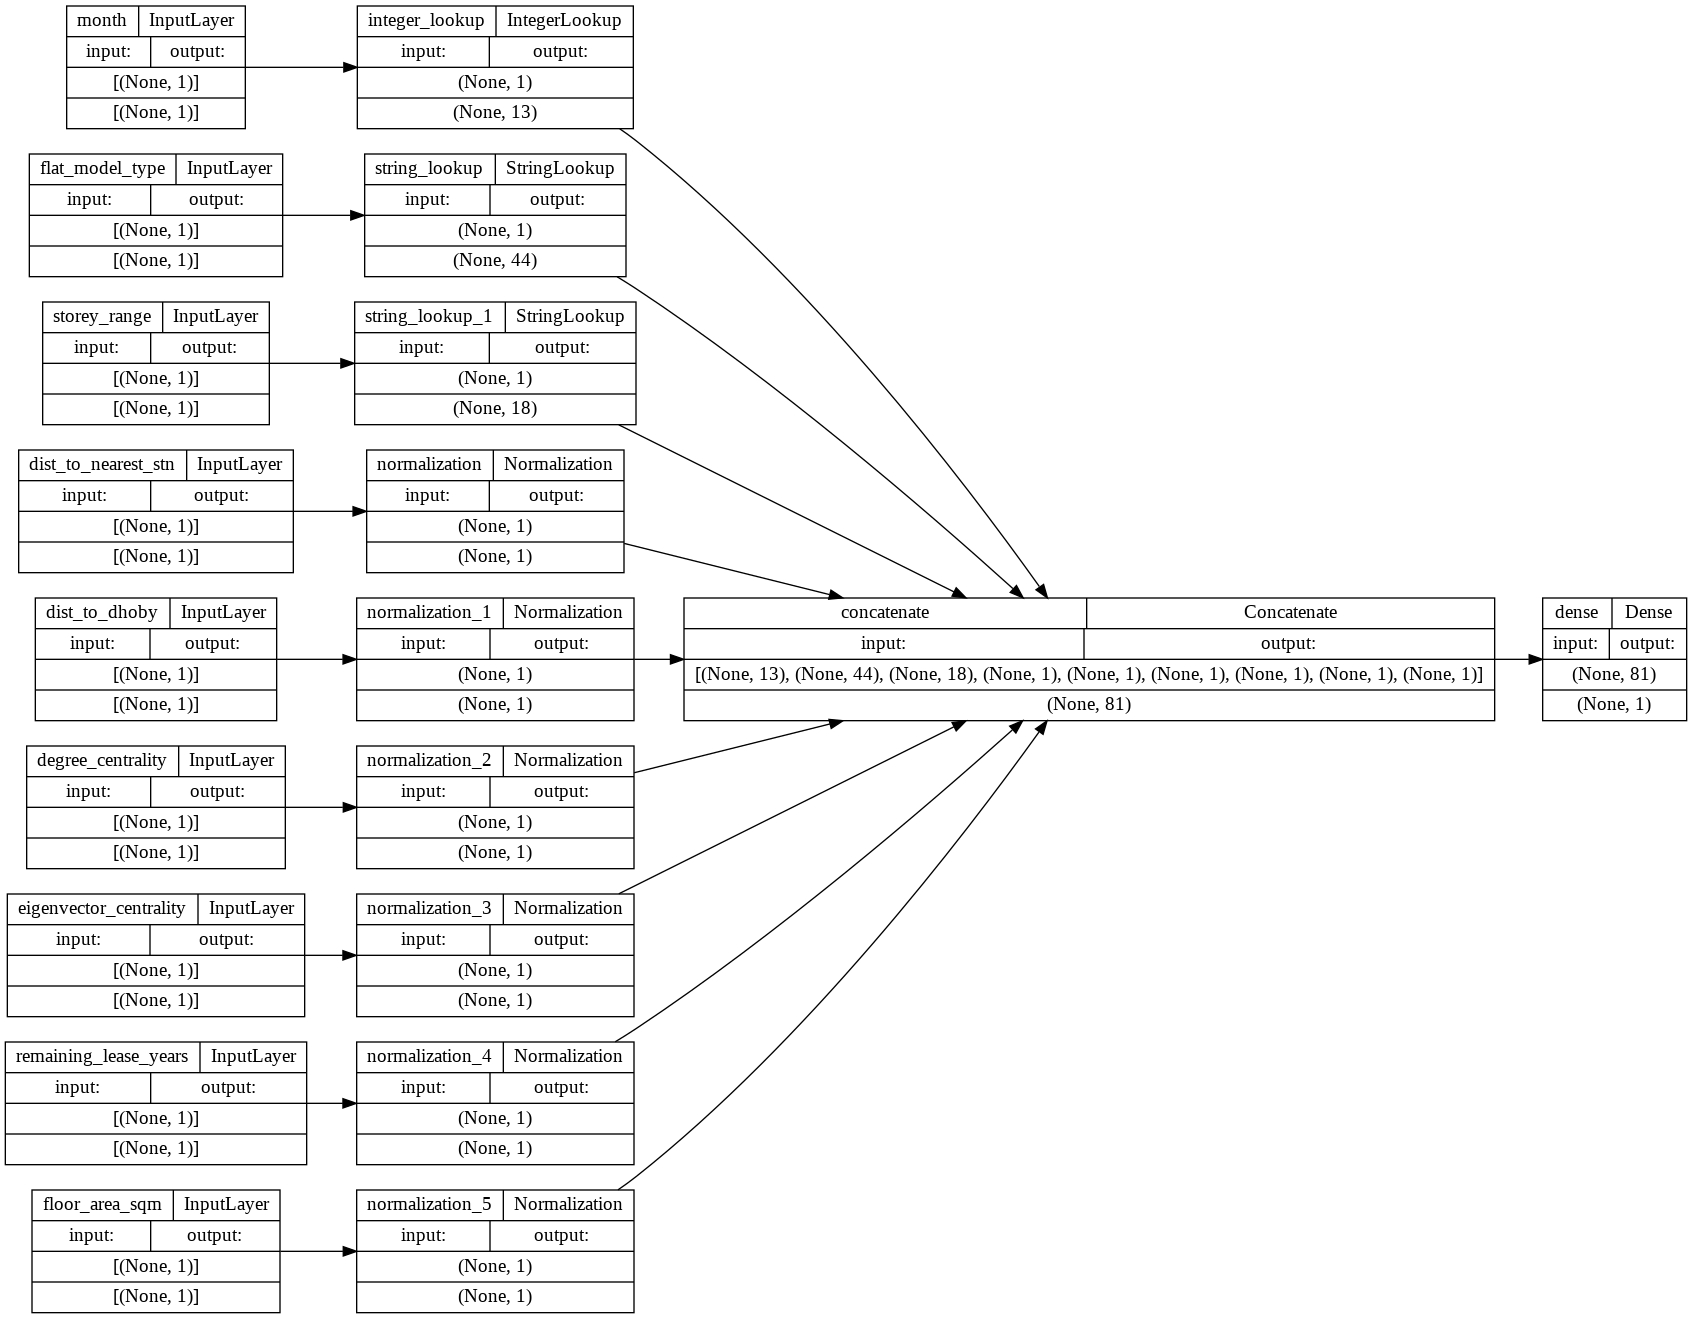

In [ ]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

####**c) The team suggests you to train the model for 50 epochs using mini-batch gradient descent with batch size = 256, Adam optimiser (with a default learning rate of 𝛼 =0.001) and mean square error as cost function. However, you find that your results are far off from their model. Change the optimiser to SGD (with default learning rate of 𝛼 = 0.01) and observe how the problem gets fixed. Report the test R2 value and explain why the change to SGD fixes the problem faced when using Adam optimiser. (Hint: Look carefully at how Adam is implemented and see how SGD is different.)**

**Adam Optimizer**

Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. It combines two gradient descent methods: Momentum and Root Mean Square Propagation (RMSP). Here, it controls the rate of gradient descent to achive minimum oscillation when it reaches the global minimum while taking big enough steps (step-size) so as to pass the local minima hurdles along the way. Hence, combining the features of the above methods to reach the global minimum efficiently. [1]

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="mean_squared_error",
              metrics=[r2]
              )

history = model.fit(train_ds, epochs=50, validation_data=test_ds, batch_size=batch_size, callbacks=[callback])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


342/342 [==============================] - 5s 9ms/step - loss: 219586019328.0000 - r2: -8.3474 - val_loss: 301486768128.0000 - val_r2: -10.0832
Epoch 2/50
342/342 [==============================] - 3s 8ms/step - loss: 219584692224.0000 - r2: -8.3520 - val_loss: 301485129728.0000 - val_r2: -10.0722
Epoch 3/50
342/342 [==============================] - 3s 9ms/step - loss: 219583266816.0000 - r2: -8.3501 - val_loss: 301483524096.0000 - val_r2: -10.1026
Epoch 4/50
342/342 [==============================] - 3s 8ms/step - loss: 219581956096.0000 - r2: -8.3437 - val_loss: 301481984000.0000 - val_r2: -10.0800
Epoch 5/50
342/342 [==============================] - 3s 7ms/step - loss: 219580678144.0000 - r2: -8.3458 - val_loss: 301480411136.0000 - val_r2: -10.1214
Epoch 6/50
342/342 [==============================] - 3s 7ms/step - loss: 219579432960.0000 - r2: -8.3513 - val_loss: 301478903808.0000 - val_r2: -10.0838
Epoch 7/50
342/342 [==============================] - 3s 8ms/step - loss: 2195780

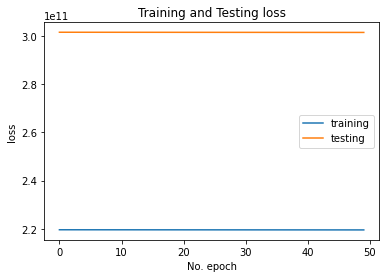

In [ ]:
# plot learning curves
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='testing')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(loc="best")
plt.title('Training and Testing loss')
plt.show()

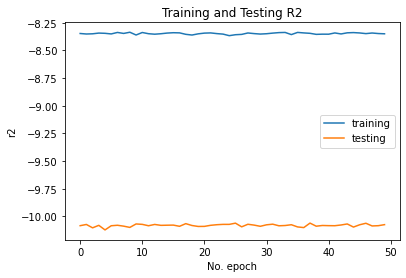

In [ ]:
# plot learning curves
plt.plot(history.history['r2'], label='training')
plt.plot(history.history['val_r2'], label='testing')
plt.ylabel('r2')
plt.xlabel('No. epoch')
plt.legend(loc="best")
plt.title('Training and Testing R2')
plt.show()

It can be seen that the loss does not decrease at all and R2 is negative which proves that the model fits the data worse than simply returning the mean of the dataset. **The test R2 is around -10.00.**

We will examine other optimizer which is SGD. 

**SGD optimizer**

SGD in Keras refers to gradient descent (with momentum) optimizer. SGD is the default optimizer for the python Keras library as of this writing. SGD differs from regular gradient descent in the way it calculates the gradient. Instead of using all the training data to calculate the gradient per epoch, it uses a randomly selected instance from the training data to estimate the gradient. This generally leads to faster convergence, but the steps are noisier because each step is an estimate. [2]

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

x = layers.Dense(1, activation="linear")(all_features)
model = keras.Model(all_inputs, x)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[r2])
history = model.fit(train_ds, epochs=50, validation_data=test_ds, batch_size=batch_size, callbacks=[callback])

Epoch 1/50
342/342 [==============================] - 4s 9ms/step - loss: 18728693760.0000 - r2: 0.1966 - val_loss: 13789996032.0000 - val_r2: 0.4958
Epoch 2/50
342/342 [==============================] - 3s 7ms/step - loss: 5481926144.0000 - r2: 0.7678 - val_loss: 12796294144.0000 - val_r2: 0.5320
Epoch 3/50
342/342 [==============================] - 3s 7ms/step - loss: 5026647552.0000 - r2: 0.7875 - val_loss: 12325089280.0000 - val_r2: 0.5501
Epoch 4/50
342/342 [==============================] - 3s 7ms/step - loss: 4776962560.0000 - r2: 0.7976 - val_loss: 12102076416.0000 - val_r2: 0.5574
Epoch 5/50
342/342 [==============================] - 3s 8ms/step - loss: 4609034240.0000 - r2: 0.8049 - val_loss: 11926617088.0000 - val_r2: 0.5641
Epoch 6/50
342/342 [==============================] - 3s 8ms/step - loss: 4482669056.0000 - r2: 0.8106 - val_loss: 11662403584.0000 - val_r2: 0.5736
Epoch 7/50
342/342 [==============================] - 3s 8ms/step - loss: 4384753664.0000 - r2: 0.8140 - 

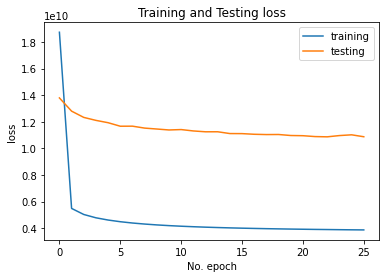

In [ ]:
# plot learning curves
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='testing')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(loc="best")
plt.title('Training and Testing loss')
plt.show()

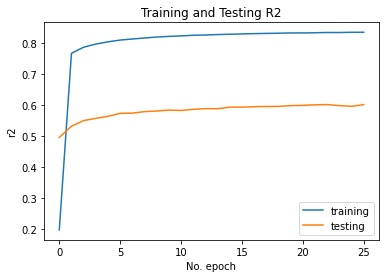

In [ ]:
# plot learning curves
plt.plot(history.history['r2'], label='training')
plt.plot(history.history['val_r2'], label='testing')
plt.ylabel('r2')
plt.xlabel('No. epoch')
plt.legend(loc="best")
plt.title('Training and Testing R2')
plt.show()

It is observed that R2 value now is positive and the loss in both training and testing decrease, which means that the model has learned from the data. **The test R2 is around 0.6.**

However, in this case, the losses reach the point where they stop decreasing and almost stay unchanged, similarly to the R2 values. The generalization gap between training and testing is big, which suggests that the model cannot generalize well.

Overall, using SGD, the model is able to learn from training, compared to using Adam optimizer. There are few reasons [3]:

- Adam finds solutions that generalize worse than those found by SGD. Even when
Adam achieves the same or lower training loss than SGD, the test performance is worse.
- Adam often displays faster initial progress on the training loss, but its performance quickly
plateaus on the test error. The model will not see the same data several times and wouldn't memorize the data without losing its generalization capability. Minimize training time may cause generalization loss.
- Learning rate and weight decay are important hyperparameters that must be tuned to do well
on each dataset.

####**d) Add 1 hidden layer (10 units) to the architecture in Q1c and train it with the same configuration as in Q1c (i.e. with Adam) except that the learning rate is increased to 0.08. Report the test R2 value.**

In [ ]:
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)
model = keras.Model(all_inputs, output)

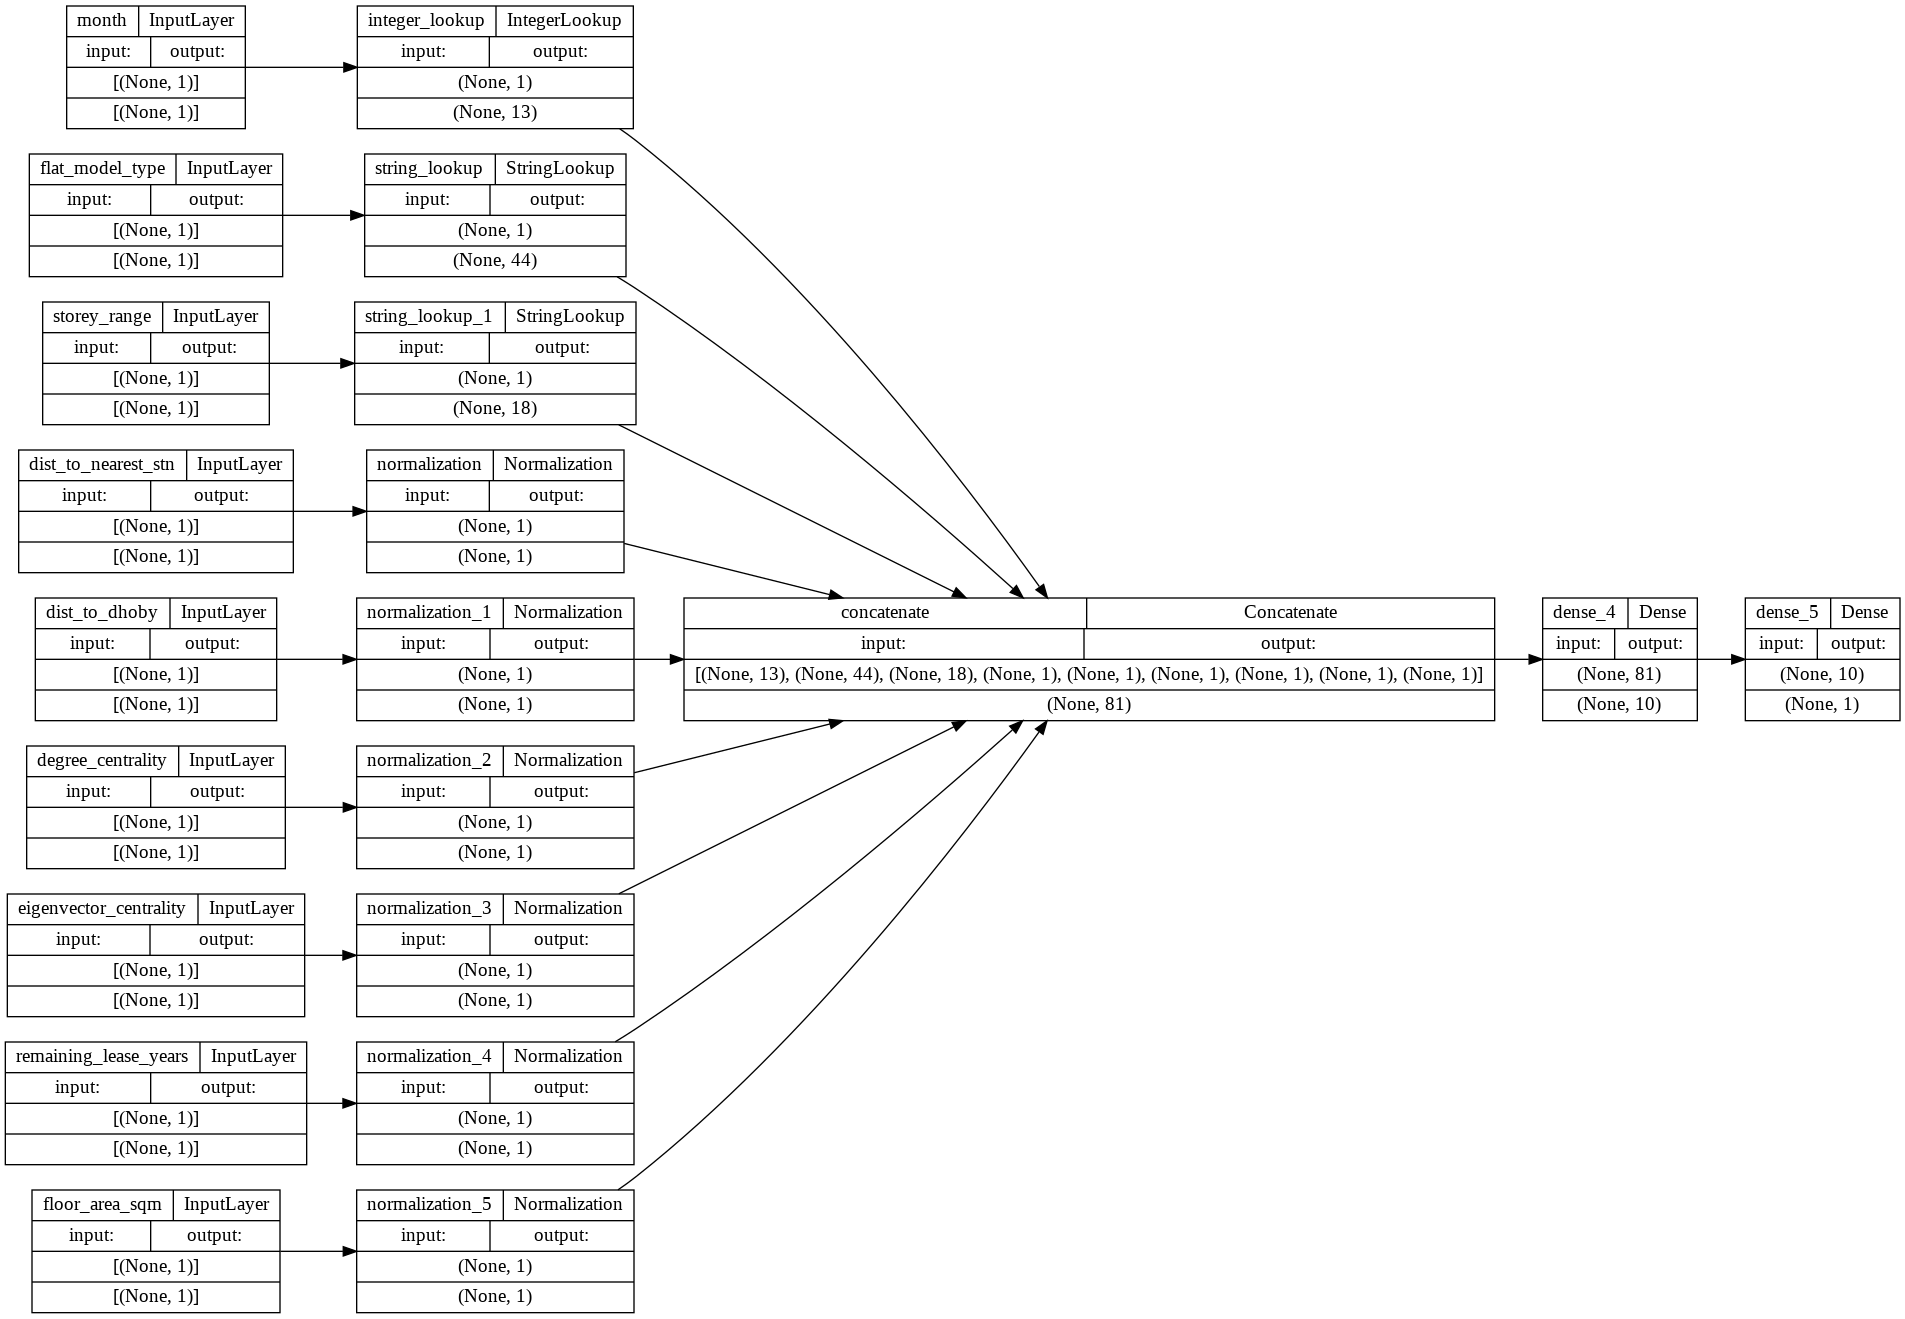

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.08),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[r2]
              )

history = model.fit(train_ds, epochs=50, validation_data=test_ds, batch_size=batch_size, callbacks=[callback])

Epoch 1/50
342/342 [==============================] - 7s 18ms/step - loss: 200432795648.0000 - r2: -7.5272 - val_loss: 228148101120.0000 - val_r2: -7.3780
Epoch 2/50
342/342 [==============================] - 4s 9ms/step - loss: 99888218112.0000 - r2: -3.2528 - val_loss: 88184029184.0000 - val_r2: -2.2353
Epoch 3/50
342/342 [==============================] - 3s 9ms/step - loss: 22998515712.0000 - r2: 0.0266 - val_loss: 25293514752.0000 - val_r2: 0.0724
Epoch 4/50
342/342 [==============================] - 3s 9ms/step - loss: 6456094720.0000 - r2: 0.7269 - val_loss: 14073494528.0000 - val_r2: 0.4861
Epoch 5/50
342/342 [==============================] - 3s 8ms/step - loss: 5167151104.0000 - r2: 0.7812 - val_loss: 12552652800.0000 - val_r2: 0.5410
Epoch 6/50
342/342 [==============================] - 3s 7ms/step - loss: 4821239808.0000 - r2: 0.7958 - val_loss: 12102542336.0000 - val_r2: 0.5574
Epoch 7/50
342/342 [==============================] - 3s 7ms/step - loss: 4560605696.0000 - r2: 

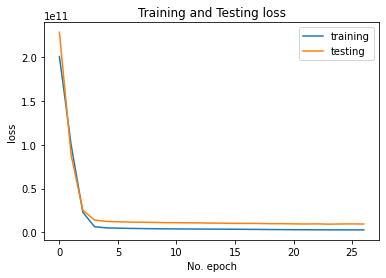

In [ ]:
# plot learning curves
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='testing')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(loc="best")
plt.title('Training and Testing loss')
plt.show()

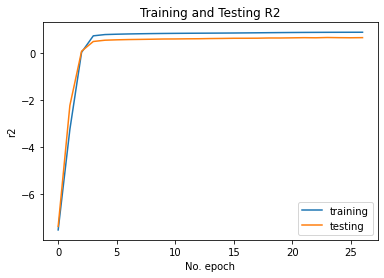

In [ ]:
# plot learning curves
plt.plot(history.history['r2'], label='training')
plt.plot(history.history['val_r2'], label='testing')
plt.ylabel('r2')
plt.xlabel('No. epoch')
plt.legend(loc="best")
plt.title('Training and Testing R2')
plt.show()

In this experiment, we obtained positive R2 (the best value in training is approximately 0.8 and **the test R2 is around 0.65**) and the loss of both training and testing data is decreased significantly. The generalization gap is also kept small and stable. The model's performance is improved. 

####**e) Compare the performance of the linear regression model to the Dense layer (Q1c) and the NN architecture (Q1d) and suggest reasons for the observations you made**

The model in Q1d (Adam with add-on layers and increased learning rate) outperforms the model in Q1c (SGD), which can be shown in both loss and R2 plots as commented above.
As we may know, if the learning rate is too small, the network will never have a chance to get where it's going. The accuracy will always be low, or training will take a really long time. here we increase the learning rate of Adam optimizer, it helps the model to be able to learn effectively. Besides, adding one more hidden layer might help the model to extract more features and may increase the accuracy.

# **References**

[1] https://www.geeksforgeeks.org/intuition-of-adam-optimizer/

[2] https://kyle-r-kieser.medium.com/tuning-your-keras-sgd-neural-network-optimizer-768536c7ef0

[3] Adam vs. SGD: Closing the generalization gap on image classification https://opt-ml.org/papers/2021/paper53.pdf